ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


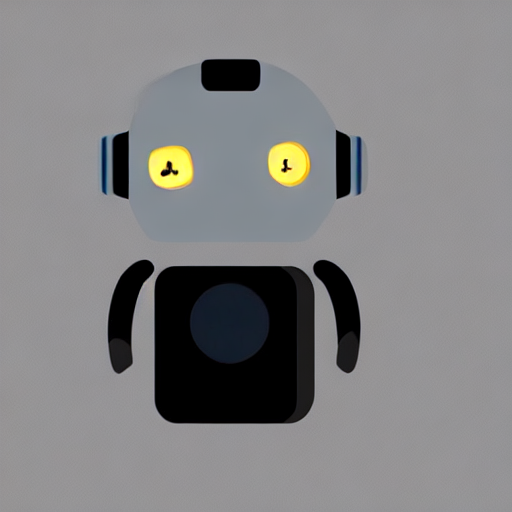

In [16]:
!pip -q install -U diffusers transformers accelerate safetensors pillow
!pip -q install --force-reinstall "pillow<12"

import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import numpy as np

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
).to("cuda")

device="cuda"
dtype=torch.float16

tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
unet = pipe.unet
vae = pipe.vae
scheduler = pipe.scheduler

@torch.no_grad()
def manual_generate(prompt, steps=20, guidance=7.5, h=512, w=512):
    # prompt embeds (pipe 내부 로직 사용)
    prompt_embeds = pipe._encode_prompt(
        prompt, device, 1, do_classifier_free_guidance=True, negative_prompt=None
    ).to(dtype)

    scheduler.set_timesteps(steps, device=device)
    latents = torch.randn(
        (1, unet.config.in_channels, h//8, w//8),
        device=device, dtype=dtype
    )
    latents = latents * scheduler.init_noise_sigma

    for t in scheduler.timesteps:
        latent_in = torch.cat([latents, latents], dim=0)
        latent_in = scheduler.scale_model_input(latent_in, t)

        noise_pred = unet(latent_in, t, encoder_hidden_states=prompt_embeds).sample
        noise_uncond, noise_text = noise_pred.chunk(2)
        noise_pred = noise_uncond + guidance * (noise_text - noise_uncond)

        latents = scheduler.step(noise_pred, t, latents).prev_sample

    img = vae.decode(latents / vae.config.scaling_factor).sample
    img = (img / 2 + 0.5).clamp(0, 1)[0].permute(1,2,0).float().cpu().numpy()
    return Image.fromarray((img*255).astype(np.uint8))

manual_generate("a simple cute robot, flat illustration, white background", steps=20)